# Tropical Cyclone Multi-Label Image Classification
## 3 Epochs, 1024 hidden layers, compare binary cross-entropy to soft F1

In [23]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from time import time
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers

from utils import *

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

## Read in metadata

In [24]:
grey_metadata = pd.read_csv("csv/2km_metadata.csv")
print("Number of images: {}\n".format(len(grey_metadata)))
grey_metadata.sample(6)

Number of images: 80052



,storm,vmax,scene,cat,year,id,image,exists
26331,2014ep14,79.6,UNIFRM,CAT1,2014,2014ep14_4kmsrbdc_201409051230,https://rammb-data.cira.colostate.edu/tc_realt...,True
37996,2017ep04,102.0,EYE,CAT3,2017,2017ep04_4kmsrbdc_201706262230,https://rammb-data.cira.colostate.edu/tc_realt...,True
51066,2017al17,92.4,EYE,CAT2,2017,2017al17_4kmsrbdc_201710122245,https://rammb-data.cira.colostate.edu/tc_realt...,True
32514,2017ep10,47.0,CRVBND,TS,2017,2017ep10_4kmsrbdc_201707282300,https://rammb-data.cira.colostate.edu/tc_realt...,True
79774,2017al10,32.0,CRVBND,TD,2017,2017al10_4kmsrbdc_201708272315,https://rammb-data.cira.colostate.edu/tc_realt...,True
34100,2016al06,41.0,CRVBND,TS,2016,2016al06_4kmsrbdc_201608172215,https://rammb-data.cira.colostate.edu/tc_realt...,True


## Data preparation

### Analyze label frequencies

In [25]:
# add labels column
grey_metadata['labels'] = grey_metadata.cat + ',' + grey_metadata.scene
grey_metadata.head(3)

,storm,vmax,scene,cat,year,id,image,exists,labels
0,2012al09,30.0,RCDO,TD,2012,2012al09_4kmsrbdc_201208210915,https://rammb-data.cira.colostate.edu/tc_realt...,True,"TD,RCDO"
1,2012al09,30.0,UNIFRM,TD,2012,2012al09_4kmsrbdc_201208210945,https://rammb-data.cira.colostate.edu/tc_realt...,True,"TD,UNIFRM"
2,2012al09,30.0,UNIFRM,TD,2012,2012al09_4kmsrbdc_201208211015,https://rammb-data.cira.colostate.edu/tc_realt...,True,"TD,UNIFRM"


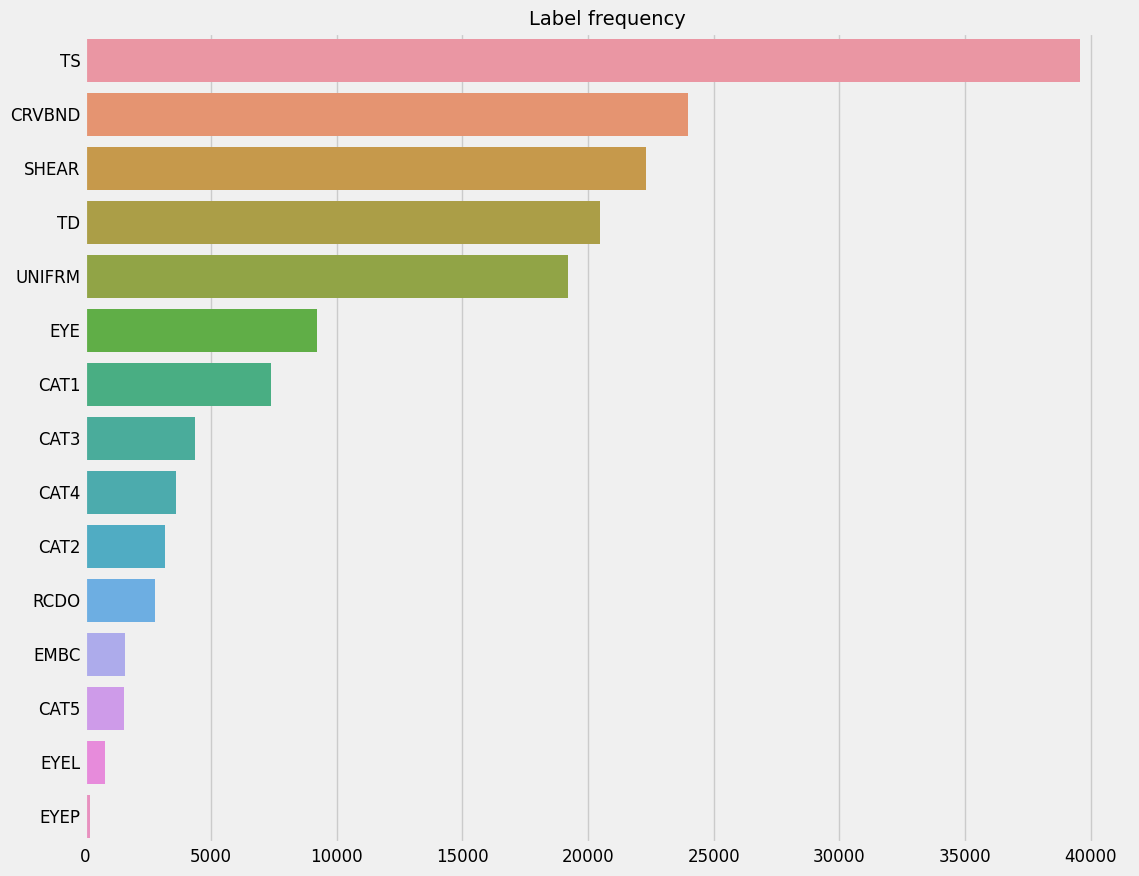

In [26]:
# Get label frequencies in descending order
label_freq = grey_metadata['labels'].apply(lambda s: str(s).split(',')).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Dealing with low label count
The labels `EYE`, `EYEL` and `EYEP` all refer to storms with a visible eye, so I will collapse those categories into one. 

In [27]:
grey_metadata['scene'] = grey_metadata.scene.replace('EYEL','EYE').replace('EYEP','EYE')
grey_metadata['labels'] = grey_metadata.cat + ',' + grey_metadata.scene
print(grey_metadata.scene.value_counts())
print(grey_metadata.cat.value_counts())

CRVBND    23966
SHEAR     22313
UNIFRM    19204
EYE       10208
RCDO       2771
EMBC       1590
Name: scene, dtype: int64
TS      39547
TD      20482
CAT1     7378
CAT3     4350
CAT4     3593
CAT2     3176
CAT5     1526
Name: cat, dtype: int64


In [28]:
# Transform labels column into a list of labels
grey_metadata['labels'] = grey_metadata['labels'].apply(lambda s: str(s).split(','))
grey_metadata.head(3)

,storm,vmax,scene,cat,year,id,image,exists,labels
0,2012al09,30.0,RCDO,TD,2012,2012al09_4kmsrbdc_201208210915,https://rammb-data.cira.colostate.edu/tc_realt...,True,"[TD, RCDO]"
1,2012al09,30.0,UNIFRM,TD,2012,2012al09_4kmsrbdc_201208210945,https://rammb-data.cira.colostate.edu/tc_realt...,True,"[TD, UNIFRM]"
2,2012al09,30.0,UNIFRM,TD,2012,2012al09_4kmsrbdc_201208211015,https://rammb-data.cira.colostate.edu/tc_realt...,True,"[TD, UNIFRM]"


In [29]:
# check that images exist for each observation
grey_metadata['exists'] = grey_metadata['id'].apply(lambda x: os.path.isfile('images/2km_relative_infrared/small/' + x + '.jpg'))
grey_metadata = grey_metadata[grey_metadata.exists == True].reset_index(drop=True)
grey_metadata.year.value_counts()

2018    11484
2016     9240
2020     9167
2017     8481
2015     8236
2012     7848
2014     7417
2021     7087
2019     6249
2013     4839
Name: year, dtype: int64

### Train/Test/Validation split
I'll be manually splitting out 2021 data as the test set, and reserving 20 percent of the training set for validation.

In [30]:
X_test = grey_metadata[grey_metadata.year.astype(str)=='2021']
X_test = X_test.drop(columns=['storm','vmax','scene','cat','year','image','exists']).reset_index(drop=True)
X_test

,id,labels
0,2021ep05_4kmsrbdc_202106250830,"[TS, CRVBND]"
1,2021ep05_4kmsrbdc_202106250900,"[TS, CRVBND]"
2,2021ep05_4kmsrbdc_202106250930,"[TS, CRVBND]"
3,2021ep05_4kmsrbdc_202106251000,"[TS, CRVBND]"
4,2021ep05_4kmsrbdc_202106251030,"[TS, UNIFRM]"
...,...,...
7082,2021al09_4kmsrbdc_202108271400,"[TS, UNIFRM]"
7083,2021al09_4kmsrbdc_202108271430,"[TS, UNIFRM]"
7084,2021al09_4kmsrbdc_202108271500,"[TS, UNIFRM]"
7085,2021al09_4kmsrbdc_202108271530,"[TS, UNIFRM]"


In [31]:
X_train = grey_metadata[grey_metadata.year.astype(str)!='2021']
X_train = X_train.drop(columns=['storm','vmax','scene','cat','year','image','exists']).reset_index(drop=True)
X_train

,id,labels
0,2012al09_4kmsrbdc_201208210915,"[TD, RCDO]"
1,2012al09_4kmsrbdc_201208210945,"[TD, UNIFRM]"
2,2012al09_4kmsrbdc_201208211015,"[TD, UNIFRM]"
3,2012al09_4kmsrbdc_201208211045,"[TD, UNIFRM]"
4,2012al09_4kmsrbdc_201208211115,"[TD, CRVBND]"
...,...,...
72956,2016al16_4kmsrbdc_201611250845,"[CAT1, CRVBND]"
72957,2016al16_4kmsrbdc_201611250915,"[CAT1, CRVBND]"
72958,2016al16_4kmsrbdc_201611250945,"[CAT1, CRVBND]"
72959,2016al16_4kmsrbdc_201611251015,"[CAT1, CRVBND]"


In [32]:
X_train, X_val, y_train, y_val = train_test_split(X_train['id'], X_train['labels'], test_size=0.2, random_state=42)
print("Number of images for training: ", len(X_train))
print("Number of images for validation: ", len(X_val))

Number of images for training:  58368
Number of images for validation:  14593


We need to complete the full path to locate training and test images from the current working directory.


In [33]:
X_train = [os.path.join('images/2km_relative_infrared/small/', str(f)+'.jpg') for f in X_train]
X_val = [os.path.join('images/2km_relative_infrared/small/', str(f)+'.jpg') for f in X_val]
X_train[:3]

['images/2km_relative_infrared/small/2015ep12_4kmsrbdc_201508290700.jpg',
 'images/2km_relative_infrared/small/2013ep08_4kmsrbdc_201308052200.jpg',
 'images/2km_relative_infrared/small/2020al29_4kmsrbdc_202011120700.jpg']

We need the targets to be a list of list of strings in order to fit a binarizer (multi-hot encoding).

In [34]:
y_train = list(y_train)
y_val = list(y_val)
y_train[:3]

[['CAT1', 'UNIFRM'], ['TS', 'UNIFRM'], ['TS', 'CRVBND']]

### Image examples
Let's display some examples of training images.

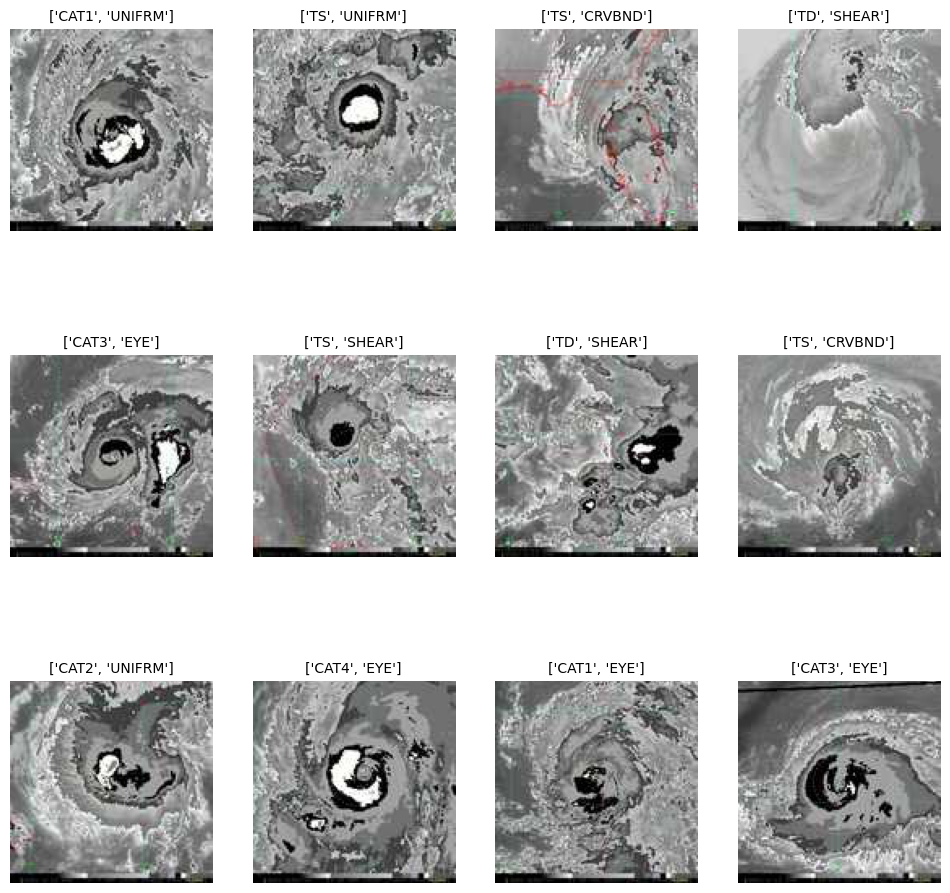

In [35]:
nobs = 12 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

### Label encoding
The original targets are lists of strings that can be easily understood by humans.  
But, if we want to build and train a neural network we need to create binary labels (multi-hot encoding).  
This is critical for multi-label classification.  

In order to binarize our labels, we will be using scikit-learn's MultiLabelBinarizer.  

In [36]:
# Fit the multi-label binarizer on the training set
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. CAT1
1. CAT2
2. CAT3
3. CAT4
4. CAT5
5. CRVBND
6. EMBC
7. EYE
8. RCDO
9. SHEAR
10. TD
11. TS
12. UNIFRM


In [37]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

## Using tf.data to build an input pipeline

In [39]:
IMG_SIZE = 224
CHANNELS = 3

# function to parse image files into image and label arrays
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    
    # Resize and normalize
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [40]:
# I'm using AUTOTUNE to dynamically reduce idle time while training

BATCH_SIZE = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE 
SHUFFLE_BUFFER_SIZE = 1024 

In [41]:
# Create dataset for tensorflow
def create_dataset(filenames, labels, is_training=True):
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [42]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

## Using Transfer Learning

In [43]:
# I'm using MobileNet V2 from TensorFlow Hub
trained_model = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
trained_model_layer = hub.KerasLayer(trained_model,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

# freeze the pre-trained layers
trained_model_layer.trainable = False

In [44]:
# define model 
model = tf.keras.Sequential([
    trained_model_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output') # using sigmoid for multilabel
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 hidden_layer (Dense)        (None, 1024)              1311744   
                                                                 
 output (Dense)              (None, 13)                13325     
                                                                 
Total params: 3,583,053
Trainable params: 1,325,069
Non-trainable params: 2,257,984
_________________________________________________________________


## Model training and evaluation

In [48]:
LR = 1e-5 
EPOCHS = 10

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1])

### Train the model using the binary cross-entropy loss

In [53]:
model_bce = tf.keras.Sequential([
    trained_model_layer,
    layers.Dense(N_LABELS, activation='sigmoid')
])

model_bce.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1])
    
start = time()
history_bce = model_bce.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=create_dataset(X_val, y_val_bin))
print('\nTraining took {}'.format(print_time(time()-start)))

Epoch 1/10


2022-03-25 09:10:42.746277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


228/228 [==============================] - ETA: 0s - loss: 0.3150 - macro_f1: 0.2076

2022-03-25 09:14:47.788127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


228/228 [==============================] - 308s 1s/step - loss: 0.3150 - macro_f1: 0.2076 - val_loss: 0.2766 - val_macro_f1: 0.2693
Epoch 2/10
228/228 [==============================] - 310s 1s/step - loss: 0.2693 - macro_f1: 0.2874 - val_loss: 0.2651 - val_macro_f1: 0.2896
Epoch 3/10
228/228 [==============================] - 310s 1s/step - loss: 0.2605 - macro_f1: 0.3079 - val_loss: 0.2593 - val_macro_f1: 0.3094
Epoch 4/10
228/228 [==============================] - 310s 1s/step - loss: 0.2552 - macro_f1: 0.3186 - val_loss: 0.2559 - val_macro_f1: 0.3136
Epoch 5/10
228/228 [==============================] - 313s 1s/step - loss: 0.2516 - macro_f1: 0.3262 - val_loss: 0.2528 - val_macro_f1: 0.3207
Epoch 6/10
228/228 [==============================] - 312s 1s/step - loss: 0.2486 - macro_f1: 0.3333 - val_loss: 0.2510 - val_macro_f1: 0.3221
Epoch 7/10
228/228 [==============================] - 311s 1s/step - loss: 0.2463 - macro_f1: 0.3388 - val_loss: 0.2499 - val_macro_f1: 0.3320
Epoch 8/10

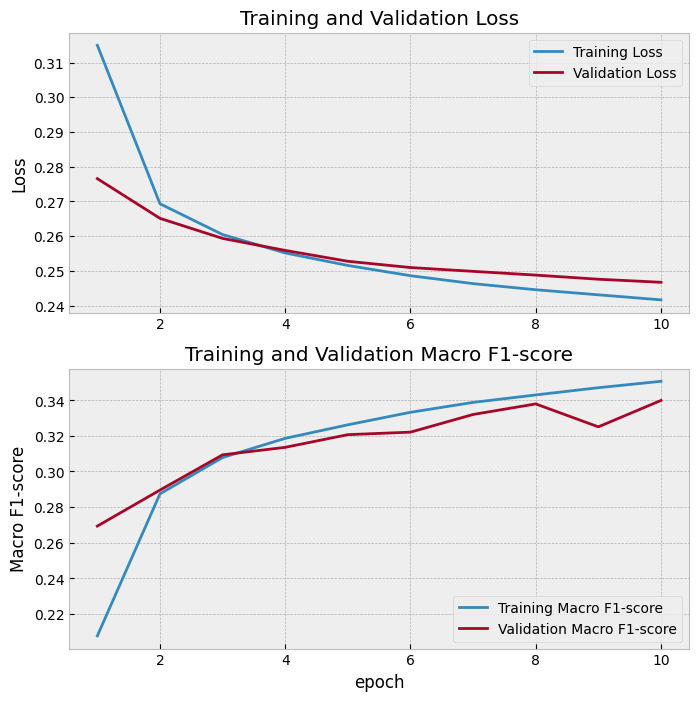

In [54]:
model_bce_losses, model_bce_val_losses, model_bce_macro_f1s, model_bce_val_macro_f1s = learning_curves(history_bce)

In [55]:
print("Macro soft-F1 loss: %.2f" %model_bce_val_losses[-1])
print("Macro F1-score: %.2f" %model_bce_val_macro_f1s[-1])

Macro soft-F1 loss: 0.25
Macro F1-score: 0.34


### Second Model (using macro soft-F1 loss)

I'm interested in seeing how optimizing on a probabilistic F1-score will change the model

In [56]:
@tf.function
def macro_soft_f1(y, y_hat):
 
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [57]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
  
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [59]:
# start = time()
# history = model.fit(train_ds,
#                     epochs=EPOCHS,
#                     validation_data=create_dataset(X_val, y_val_bin))
# print('\nTraining took {}'.format(print_time(time()-start)))

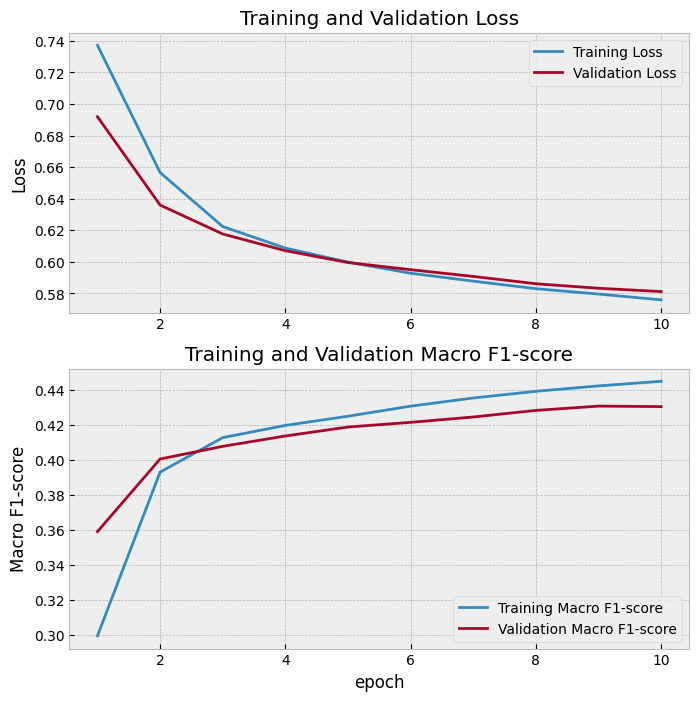

In [50]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history)

In [51]:
# Print performance on the validation set
print("Macro F1 loss: %.2f" %val_losses[-1])
print("Macro F1-score: %.2f" %val_macro_f1s[-1])

Macro F1 loss: 0.58
Macro F1-score: 0.43


##  Show model predictions

In [60]:
def show_prediction(storm, df, model):
    
    # Get storm image info
    storm_id = storm
    labels = X_test.loc[X_test['id']==storm]['labels']
    img_path = os.path.join('images/2km_relative_infrared/small/', str(storm_id)+'.jpg')

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # Display image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\n\n{}\n\nLabels\n{}\n\nPrediction\n{}\n'.format(storm, labels, list(prediction)), fontsize=9)
    plt.show()

2022-03-25 10:05:04.626424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


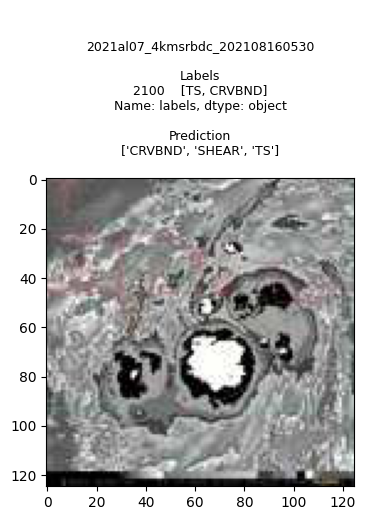

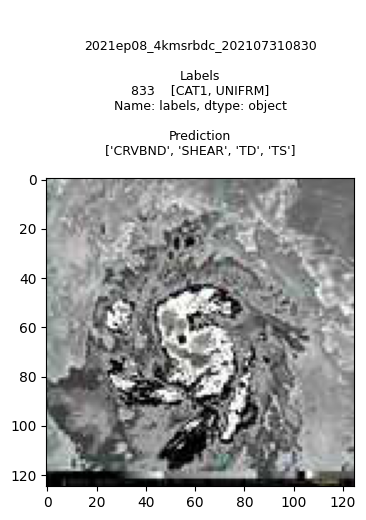

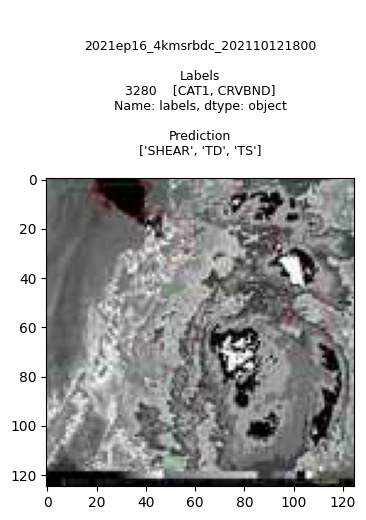

In [61]:
storms = ['2021al07_4kmsrbdc_202108160530','2021ep08_4kmsrbdc_202107310830',
          '2021ep16_4kmsrbdc_202110121800']

for s in storms:
    show_prediction(s, X_test, model)

In [ ]:
storm = '2012ep15_4kmsrbdc_201210070530'
storm_id = storm
labels = grey_metadata.loc[grey_metadata['id']==storm]['labels']
labels

## Export models

In [ ]:
t = datetime.now().strftime("%Y%m%d_%H%M%S")
export_path = "./models/macro-f1_10_{}".format(t)
model.save(export_path)
print("Model with macro soft-f1 was exported in this path: '{}'".format(export_path))

export_path_bce = "./models/bce_10{}".format(t)
model_bce.save(export_path_bce)
print("Model with bce was exported in this path: '{}'".format(export_path_bce))